# Computer Vision: Plants Classification Other models

This classification is based on the **Plant Seedlings Dataset**, which contains images of approximately 960 unique plants belonging to 12 species at several growth stages, with a resolution of about 10 pixels per mm of annotated RGB images.

The dataset includes the following species:


|English     |Latin               |EPPO|
|:-----------|:-------------------|:---|
|Maize       |Zea mays L.         |ZEAMX|
|Common wheat|Triticum aestivum L.|TRZAX|
|Sugar beet|Beta vulgaris var. altissima|BEAVA|
|Scentless Mayweed|Matricaria perforata Mérat|MATIN|
|Common Chickweed|Stellaria media|STEME|
|Shepherd’s Purse|Capsella bursa-pastoris|CAPBP|
|Cleavers|Galium aparine L.|GALAP|
|Charlock|Sinapis arvensis L.|SINAR|
|Fat Hen|Chenopodium album L.|CHEAL|
|Small-flowered Cranesbill|Geranium pusillum|GERSS|
|Black-grass|Alopecurus myosuroides|ALOMY|
|Loose Silky-bent|Apera spica-venti|APESV|

In [1]:
%matplotlib inline
# %load_ext watermark
# %watermark -v -m -p numpy,pandas,sklearn,tensorflow -g

import re
import os
import sys
from time import time
import pickle
import pathlib
import itertools
import numpy as np
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# import watermark

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

In [2]:
# Libraries specific of Deep learning and images
import imageio
from skimage.transform import resize as imresize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input, Activation, Maximum, ZeroPadding2D, concatenate, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [3]:
sys.path.append(os.pardir)
from src.log_manager import Logger
logger = Logger("CNN", "cnn_logs.txt", file_path=os.getcwd(), level="INFO")

## 1. Loading data

### 1.1 Using previous notebook dataset

In [4]:
PLANT_CLASSES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 
                 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 
                 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
CLASSES_DICT_NAMES = {name: k for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
CLASSES_DICT_NUM = {k: name for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
NUM_CATEGORIES = len(PLANT_CLASSES)

In [5]:
def get_abbreviation(name):
    split_regex = re.compile("[ \-,;:]")
    splitted = split_regex.split(name)
    if len(splitted) == 1:
        return splitted[0][:2].upper()
    else:
        return "".join([k[0].upper() for k in splitted])

ABBREVIATIONS = [get_abbreviation(m) for m in PLANT_CLASSES]
print(f"Abbreviations: {ABBREVIATIONS}")

RESHAPE_SIZE = (65, 65, 3)

Abbreviations: ['BG', 'CH', 'CL', 'CC', 'CW', 'FH', 'LSB', 'MA', 'SM', 'SP', 'SFC', 'SB']


In [6]:
# Read variables
%store -r dataset
images_generated, labels_encoded, X_val, Y_val = dataset

## 2. Model
### 2.1 Model definition



In [7]:
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3), strides=(1,1), zp_flag=False):
    if zp_flag:
        zp = ZeroPadding2D((1,1))(feature_batch)
    else:
        zp = feature_batch
    conv = Conv2D(filters=feature_map, 
                  kernel_size=kernel_size, 
                  data_format = 'channels_last',
                  strides=strides)(zp)
    bn = BatchNormalization(axis=3)(conv)
    act = LeakyReLU(1/10)(bn)
    return act


def dense_set(inp_layer, n, activation, drop_rate=0.3):
    dp = Dropout(drop_rate)(inp_layer)
    dns = Dense(n)(dp)
    bn = BatchNormalization(axis=-1)(dns)
    act = Activation(activation=activation)(bn)
    return act


def multi_conv_model(img_shape=RESHAPE_SIZE, opt_name="Adam"):
    input_img = Input(shape=img_shape)

    # First stage of Conv and Max Pooling
    conv1 = conv_layer(input_img, `
    conv2 = conv_layer(conv1, 64, zp_flag=False)
    mp1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(conv2)
    # Second stage of Conv and Max Pooling
    conv3 = conv_layer(mp1, 128)
    conv4 = conv_layer(conv3, 128)
    mp2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(conv4)
    # Third stage
    conv7 = conv_layer(mp2, 256)
    conv8 = conv_layer(conv7, 256)
    conv9 = conv_layer(conv8, 256)
    mp3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # Apply dense layers
    flt = Flatten()(mp3)
    ds1 = dense_set(flt, 128, activation='tanh')
    out = dense_set(ds1, 12, activation='softmax')

    model = Model(inputs=input_img, outputs=out)
    
    # The first 50 epochs are used by Adam opt.
    # Then 30 epochs are used by SGD opt.
    if opt_name == "Adam":
        model_optimizer = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    elif opt_name == "SGD":
        model_optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
    else:
        raise ValueError("Selected optimizer not supported")
    model.compile(loss='categorical_crossentropy',
                   optimizer=model_optimizer,
                   metrics=['accuracy'])
    # Display the model's architecture
    model.summary()
    return model

In [18]:
def get_callbacks(filepath=None, save_best=True, learning_schedule="Plateau", patience=6):
    callbacks = []
    
    if learning_schedule == "Plateau":
        # Reduce learning rate when a metric has stopped improving
        lr_schedule = ReduceLROnPlateau(monitor='val_acc', 
                                      factor=0.1, 
                                      min_delta=1e-5, 
                                      patience=patience, 
                                      verbose=1)
    elif learning_schedule == "Annealer":
        # Decrease each epoch
        lr_schedule = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=1)
    
    callbacks.append(lr_schedule)
    
    if filepath:
        # Save the model after every epoch
        msave = ModelCheckpoint(filepath, save_best_only=save_best)
        callbacks.append(msave)
        
    return callbacks


def train_model(images_generated, labels_encoded, batch_size=86, epochs=50, opt="Adam", 
                weights_file=None, save_to=None, save_best=False):
    if save_to:
        callbacks = get_callbacks(filepath=save_to, save_best=save_best, patience=6)
    else:
        callbacks = get_callbacks(patience=6)
    # Model architecture and compile
    plant_model = multi_conv_model(opt_name=opt)
    if weights_file:
        if os.path.exists(weights_file):
            plant_model.load_weights(filepath=weights_file)
                
    datagen = ImageDataGenerator(
        rotation_range=360.,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        data_format="channels_last")
    
    X_tr, X_val, Y_tr, Y_val = train_test_split(images_generated, labels_encoded, test_size=0.1)
    
    history = plant_model.fit_generator(
        datagen.flow(X_tr, Y_tr, batch_size=batch_size),
        steps_per_epoch=10*len(X_tr)/batch_size,
        epochs=epochs,
        verbose=2,
        shuffle=True,
        validation_data=(X_te, Y_te),
        callbacks=callbacks)
    return plant_model, history

In [9]:
# Training first 30 epochs with SGD and later on with Adam
ADAM_MODEL = "./models/CNN_model2_weights_Adam.hdf5"
SGD_MODEL = "./models/CNN_model2_weights_SGD.hdf5"
SAVE_MODEL_TO = "./models/model2_weights.hdf5"  # .{epoch:02d}

In [8]:
# %%time
# model, history_m2_1 = train_model(X_tr, Y_tr, X_te, Y_te, 
#                            batch_size=86, 
#                            epochs=5, 
#                            opt="SGD", 
#                            weights_file=SGD_MODEL, save_to=SAVE_MODEL_TO, save_best=True)

In [9]:
# %%time
# model, history_m2_1 = train_model(X_tr, Y_tr, X_te, Y_te, 
#                            batch_size=86, 
#                            epochs=5, 
#                            opt="Adam", 
#                            weights_file=SGD_MODEL, save_to=SAVE_MODEL_TO, save_best=True)

In [10]:
# Save in checkpoint format  (to load it use 'model.load_weights')
# model.save_weights('./models/checkpoints/model2_CNN_SGD')

# Save model weights only (h5 format):
# model.save_weights('./models/model2_weights_final.h5')

### Load saved model

In [12]:
# Load from saved model weights
model = multi_conv_model(opt_name="Adam")
model.load_weights('./models/model2_weights_final.h5')

W1031 16:59:00.046297 140526915999552 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65, 65, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 63, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 61, 61, 64)        0     

### Get predictions for the validation set

In [6]:
VALIDATION_DATA = "./data/plants/validation.gz"

val_data = pd.read_csv(VALIDATION_DATA)
val_data['class'] = val_data['class'].apply(lambda x: CLASSES_DICT_NAMES[x.replace("’", "")])
val_info = val_data[['label', 'class']]
X_val = val_data.drop(labels=['label', 'class'], axis=1)

# Apply the shape required
X_val = X_val.values.reshape(-1, *RESHAPE_SIZE)
Y_val = to_categorical(val_info['class'].values, num_classes=len(CLASSES_DICT_NAMES))

In [14]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1) 
# compute the confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred_classes) 

### Confusion Matrix

In [55]:
def plot_confusion_matrix(cnf_matrix, abbreviations=None, output=None ,size=12):
    # plot the confusion matrix
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(cnf_matrix, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f',ax=ax)
    if abbreviations:
        ax.set_xticklabels(abbreviations)
        ax.set_yticklabels(abbreviations)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    if output:
        fig.savefig(output, dpi=300)

# plot the confusion matrix
plot_confusion_matrix(cnf_matrix, abbreviations=ABBREVIATIONS, output='./fig/model2_CNN_confusion_matrix.png')

### Other metrics

In [47]:
print(f'Accuracy: \t{accuracy_score(Y_true, Y_pred_classes):.3}')
print(f'Precision: \t{[round(k, 3) for k in precision_score(Y_true, Y_pred_classes, average=None)]}')
print(f'Recall: \t{[round(k, 3) for k in recall_score(Y_true, Y_pred_classes, average=None)]}')
print(f'F1 score: \t{[round(k, 3) for k in f1_score(Y_true, Y_pred_classes, average=None)]}')

# Or all together....
print(f'\nclasification report:\n {classification_report(Y_true, Y_pred_classes)}')

Accuracy: 	0.928
Precision: 	[0.786, 0.902, 0.955, 0.994, 0.943, 1.0, 0.813, 0.984, 0.915, 0.96, 0.992, 0.971]
Recall: 	[0.506, 0.983, 0.842, 0.929, 0.909, 0.966, 0.961, 0.968, 0.987, 0.96, 0.992, 0.961]
F1 score: 	[0.615, 0.941, 0.895, 0.96, 0.926, 0.983, 0.881, 0.976, 0.95, 0.96, 0.992, 0.966]

clasification report:
               precision    recall  f1-score   support

           0       0.79      0.51      0.62        87
           1       0.90      0.98      0.94       121
           2       0.96      0.84      0.90        76
           3       0.99      0.93      0.96       168
           4       0.94      0.91      0.93        55
           5       1.00      0.97      0.98       146
           6       0.81      0.96      0.88       204
           7       0.98      0.97      0.98        63
           8       0.92      0.99      0.95       153
           9       0.96      0.96      0.96        75
          10       0.99      0.99      0.99       133
          11       0.97      0

## LeNet5 Model

In [7]:
def LeNet5_ensemble(input_shape=(28, 28, 1), nets=15):
    """
    LeNet5 based architecture with improvements:
    - Two stacked 3x3 filters replacing the single 5x5. These become nonlinear 5x5 convolutions
    - A convolution with stride 2 replaces pooling layers. These become learnable pooling layers.
    - ReLU activation replaces sigmoid.
    - Batch normalization, dropout and more features added.
    - An ensemble of 15 CNNs with bagging is used
    """
    models = [0] * nets
    for j in range(nets):
        models[j] = Sequential()
        # 
        models[j].add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
        models[j].add(BatchNormalization())
        models[j].add(Conv2D(32, kernel_size=3, activation='relu'))
        models[j].add(BatchNormalization())
        models[j].add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
        models[j].add(BatchNormalization())
        models[j].add(Dropout(0.4))

        models[j].add(Conv2D(64, kernel_size=3, activation='relu'))
        models[j].add(BatchNormalization())
        models[j].add(Conv2D(64, kernel_size=3, activation='relu'))
        models[j].add(BatchNormalization())
        models[j].add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
        models[j].add(BatchNormalization())
        models[j].add(Dropout(0.4))

        models[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
        models[j].add(BatchNormalization())
        models[j].add(Flatten())
        models[j].add(Dropout(0.4))
        models[j].add(Dense(12, activation='softmax'))

        # COMPILE: Adam Optimizer and Cross-Entropy Cost
        models[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
    return models

# Model architecture and compile
nets = 9
ensemble_model = LeNet5_ensemble(input_shape=RESHAPE_SIZE, nets=nets)

W1101 09:51:53.138483 140413034854208 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
SAVE_TO = "./models/LeNet5_weights_Adam.{j:02d}.hdf5"
# PREV_WEIGHTS = 

callbacks = []

# if os.path.exists(PREV_WEIGHTS):
#     ensemble_model.load_weights(filepath=weights_file)
    
datagen = ImageDataGenerator(
    rotation_range=360.,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last")

# TRAIN all networks
history = [0] * nets
epochs = 50
for j in range(nets):
    logger.info(f"Starting training on NN {j}")
    X_tr, X_val, Y_tr, Y_val = train_test_split(images_generated, labels_encoded, test_size=0.1)
    callbacks.append(get_callbacks(filepath=f"./models/LeNet5_weights.{j:02d}.hdf5", 
                                   save_best=True, 
                                   learning_schedule="Annealer", 
                                   patience=6))
    
    history[j] = ensemble_model[j].fit_generator(
        datagen.flow(X_tr, Y_tr, batch_size=64),
        epochs = epochs, 
        steps_per_epoch = X_tr.shape[0]//64,  
        validation_data = (X_val, Y_val), 
        callbacks=callbacks[j], 
        verbose=1)
    logger.info("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1, epochs, max(history[j].history['acc']), max(history[j].history['val_acc']) ))
    
for j in range(nets):
    ensemble_model[j].save_weights(f"./models/LeNet5_weights.{j:02d}.final.hdf5")

I1031 23:48:02.302890 140409948682048 log_manager.py:81] Starting training on NN 0



Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/50
92/92 [==============================] - 66s 718ms/step - loss: 3.4942 - acc: 0.1968 - val_loss: 5.5769 - val_acc: 0.0817

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00095.
Epoch 2/50
92/92 [==============================] - 51s 558ms/step - loss: 3.2966 - acc: 0.2670 - val_loss: 5.2747 - val_acc: 0.0923

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009025.
Epoch 3/50
92/92 [==============================] - 50s 542ms/step - loss: 2.9033 - acc: 0.3308 - val_loss: 6.9721 - val_acc: 0.1059

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000857375.
Epoch 4/50
92/92 [==============================] - 50s 547ms/step - loss: 2.6057 - acc: 0.3838 - val_loss: 6.3691 - val_acc: 0.1210

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0008145062499999999.
Epoch 5/50
92/92 [==============================] - 47s 516ms/step - loss: 2.4191 - acc: 0.4180

In [9]:
# (Optional) Load models from previous run
for j in range(nets):
    ensemble_model[j].load_weights(f"./models/LeNet5_weights.{j:02d}.hdf5")

In [51]:
# ENSEMBLE Predictions and submit
Y_pred = np.zeros( (X_val.shape[0], 12) )

for j in range(nets):
    # Sum all probabilities across all models
    Y_pred = Y_pred + ensemble_model[j].predict(X_val)
# Get the top prediction for each image
Y_pred = np.argmax(Y_pred, axis = 1)
results = pd.Series(Y_pred, name="Label")
# submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), Y_pred],axis = 1)
# submission.to_csv("Plants-CNN-Ensemble.csv",index=False)

Y_true = np.argmax(Y_val, axis=1) 
# compute the confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred) 

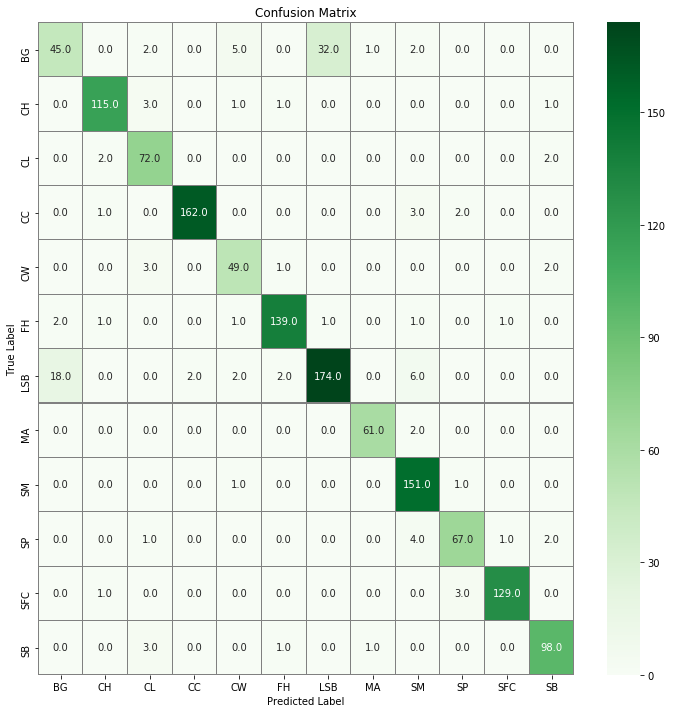

In [56]:
plot_confusion_matrix(cnf_matrix, abbreviations=ABBREVIATIONS, output='./fig/LeNet5_CNN_confusion_matrix.png')

In [57]:
print(f'Accuracy: \t{accuracy_score(Y_true, Y_pred):.3}')
print(f'Precision: \t{[round(k, 3) for k in precision_score(Y_true, Y_pred, average=None)]}')
print(f'Recall: \t{[round(k, 3) for k in recall_score(Y_true, Y_pred, average=None)]}')
print(f'F1 score: \t{[round(k, 3) for k in f1_score(Y_true, Y_pred, average=None)]}')

# Or all together....
print(f'\nclasification report:\n {classification_report(Y_true, Y_pred)}')

Accuracy: 	0.912
Precision: 	[0.692, 0.958, 0.857, 0.988, 0.831, 0.965, 0.841, 0.968, 0.893, 0.918, 0.985, 0.933]
Recall: 	[0.517, 0.95, 0.947, 0.964, 0.891, 0.952, 0.853, 0.968, 0.987, 0.893, 0.97, 0.951]
F1 score: 	[0.592, 0.954, 0.9, 0.976, 0.86, 0.959, 0.847, 0.968, 0.938, 0.905, 0.977, 0.942]

clasification report:
               precision    recall  f1-score   support

           0       0.69      0.52      0.59        87
           1       0.96      0.95      0.95       121
           2       0.86      0.95      0.90        76
           3       0.99      0.96      0.98       168
           4       0.83      0.89      0.86        55
           5       0.97      0.95      0.96       146
           6       0.84      0.85      0.85       204
           7       0.97      0.97      0.97        63
           8       0.89      0.99      0.94       153
           9       0.92      0.89      0.91        75
          10       0.98      0.97      0.98       133
          11       0.93     

### Using a Pre-Trained Model

In [ ]:
pretrained_model = tf.keras.applications.MobileNet()